In [1]:
!nvidia-smi

Mon Jun 30 13:02:50 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             12W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [2]:
import os
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, models, datasets
from torch.utils.data import DataLoader
from tqdm import tqdm
import matplotlib.pyplot as plt
import zipfile
from google.colab import drive

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [4]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406],
                             [0.229, 0.224, 0.225])
    ]),
}

In [5]:
# 1. Mount Google Drive
# Ini akan meminta otorisasi untuk mengakses Google Drive kamu.
# Jalankan ini dan ikuti petunjuknya.
drive.mount('/content/drive')

Mounted at /content/drive


In [24]:
zip_file_path = '/content/drive/MyDrive/tomat_ai/tomato.zip'

In [25]:
extract_dir = '/content/tomato_dataset'

In [26]:
os.makedirs(extract_dir, exist_ok=True)

In [27]:
print(f"Mengekstrak {zip_file_path} ke {extract_dir}...")
with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(extract_dir)
print("Ekstraksi selesai.")

Mengekstrak /content/drive/MyDrive/tomat_ai/tomato.zip ke /content/tomato_dataset...
Ekstraksi selesai.


In [28]:
data_dir = os.path.join(extract_dir, 'tomato')

In [29]:
print(f"Direktori dataset yang siap digunakan: {data_dir}")

Direktori dataset yang siap digunakan: /content/tomato_dataset/tomato


In [30]:
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}

In [31]:
dataloaders = {x: DataLoader(image_datasets[x], batch_size=32,
                             shuffle=True, num_workers=2)
               for x in ['train', 'val']}

In [32]:
# Class names
class_names = image_datasets['train'].classes
num_classes = len(class_names)

In [33]:
# Visualize one image from each class
import matplotlib.pyplot as plt
import numpy as np

def imshow(inp, title=None):
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = np.clip((inp * std + mean), 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.axis('off')

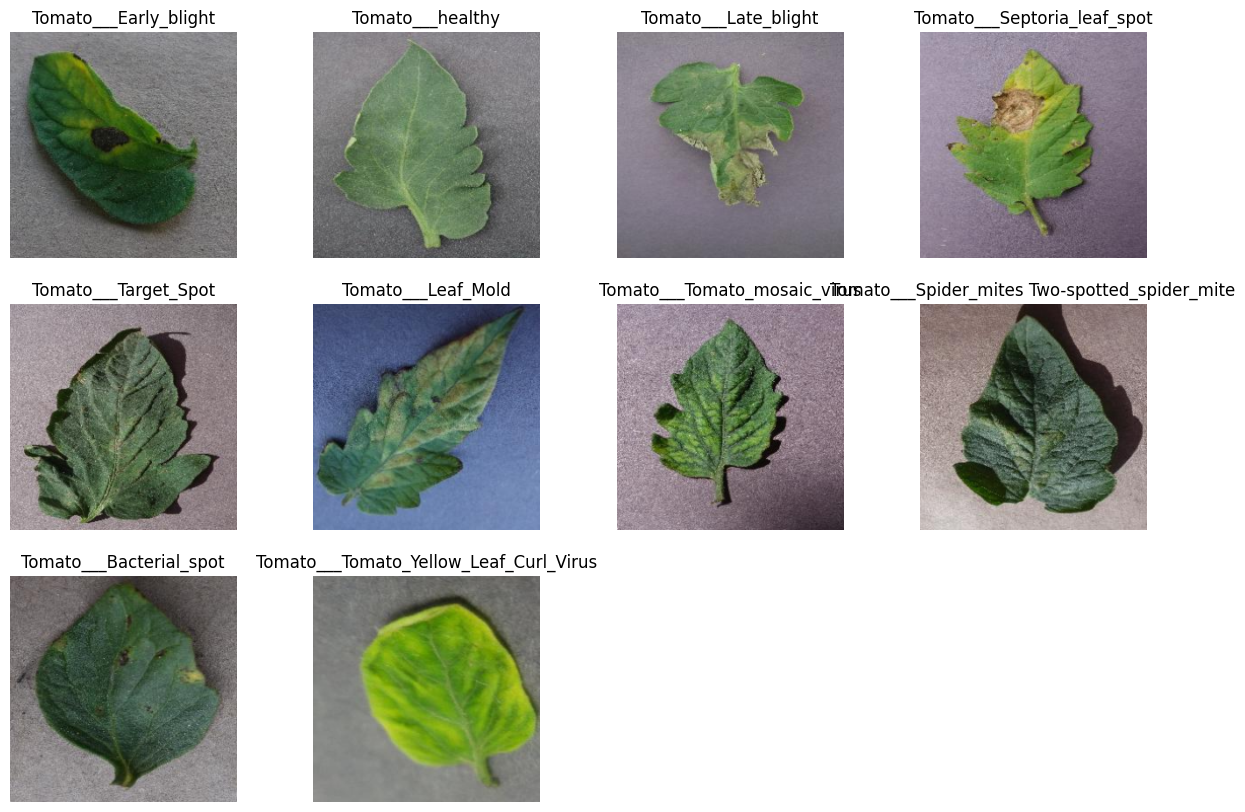

In [34]:
# Show one image per class
shown = set()
plt.figure(figsize=(15, 10))
for i, (inputs, labels) in enumerate(dataloaders['train']):
    for j in range(inputs.size(0)):
        label = labels[j].item()
        if label not in shown:
            plt.subplot(3, 4, len(shown)+1)
            imshow(inputs[j].cpu(), title=class_names[label])
            shown.add(label)
        if len(shown) == num_classes:
            break
    if len(shown) == num_classes:
        break
plt.show()

In [35]:
# Load model
model = models.mobilenet_v3_large(weights='IMAGENET1K_V1')
model.classifier[3] = nn.Linear(model.classifier[3].in_features, num_classes)

Downloading: "https://download.pytorch.org/models/mobilenet_v3_large-8738ca79.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_large-8738ca79.pth
100%|██████████| 21.1M/21.1M [00:00<00:00, 173MB/s]


In [36]:
# Send to device and enable multi-GPU if available
model = model.to(device)
if torch.cuda.device_count() > 1:
    print(f"Using {torch.cuda.device_count()} GPUs")
    model = nn.DataParallel(model)

In [37]:
# Loss, optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005)


In [38]:
# Early stopping params
best_loss = float('inf')
best_model_wts = copy.deepcopy(model.state_dict())
early_stop_counter = 0
patience = 5

In [39]:
# Logs
train_loss_list, val_loss_list = [], []
train_acc_list, val_acc_list = [], []

In [40]:
# Training loop
num_epochs = 100

In [43]:
import torch
import torch.nn as nn
import copy
from tqdm import tqdm # Pastikan tqdm sudah diimpor

# Asumsi variabel-variabel ini sudah didefinisikan sebelumnya:
# num_epochs (e.g., 100)
# dataloaders (dictionary dengan 'train' dan 'val' DataLoader)
# image_datasets (dictionary dengan 'train' dan 'val' Dataset)
# model (MobileNetV3 yang sudah dimuat)
# device (e.g., 'cuda' atau 'cpu')
# optimizer
# criterion (fungsi loss)

# --- Perbaikan Penting Dimulai di Sini ---

# Inisialisasi variabel untuk Early Stopping dan Penyimpanan Model
# 1. patience: Naikkan nilainya agar model memiliki kesempatan untuk berfluktuasi
#    atau tidak membaik selama beberapa epoch sebelum berhenti.
#    Nilai 5, 7, atau 10 adalah umum.
patience = 7 # Misalnya, biarkan model tidak membaik selama 7 epoch sebelum berhenti

early_stop_counter = 0
best_loss = float('inf') # Inisialisasi best_loss dengan nilai tak hingga positif.
                         # Ini memastikan epoch pertama (atau mana pun) yang menghasilkan
                         # loss validasi akan dianggap sebagai 'best_loss' awal.

train_loss_list = []
train_acc_list = []
val_loss_list = []
val_acc_list = []

# --- Loop Pelatihan ---
for epoch in range(num_epochs):
    print(f"\nEpoch {epoch+1}/{num_epochs}")

    for phase in ['train', 'val']:
        model.train() if phase == 'train' else model.eval()
        running_loss = 0.0
        running_corrects = 0

        dataloader = dataloaders[phase]
        # Menggunakan tqdm untuk progress bar yang lebih informatif
        phase_bar = tqdm(dataloader, desc=f"{phase.capitalize()} [{epoch+1}/{num_epochs}]", leave=False)

        for inputs, labels in phase_bar:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)
                _, preds = torch.max(outputs, 1)
                loss = criterion(outputs, labels)

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            # Memperbarui progress bar dengan metrik batch saat ini
            phase_bar.set_postfix({
                "Loss": loss.item(),
                "Acc": (torch.sum(preds == labels.data).double() / inputs.size(0)).item()
            })

        epoch_loss = running_loss / len(image_datasets[phase])
        epoch_acc = running_corrects.double() / len(image_datasets[phase])

        # Menyimpan metrik ke list
        if phase == 'train':
            train_loss_list.append(epoch_loss)
            train_acc_list.append(epoch_acc.item())
        else: # Fase 'val'
            val_loss_list.append(epoch_loss)
            val_acc_list.append(epoch_acc.item())

            # --- Logika Early Stopping ---
            if epoch_loss < best_loss: # Jika loss validasi saat ini lebih baik
                best_loss = epoch_loss # Perbarui best_loss
                best_model_wts = copy.deepcopy(model.state_dict()) # Simpan bobot terbaik
                # Perbaikan masalah '.module' saat menyimpan model
                if isinstance(model, nn.DataParallel): # Jika model di-wrap dengan DataParallel
                    torch.save(model.module.state_dict(), 'best_model.pth')
                else: # Jika tidak di-wrap (kasus umum untuk 1 GPU/CPU)
                    torch.save(model.state_dict(), 'best_model.pth')
                early_stop_counter = 0 # Reset counter karena ada peningkatan
            else: # Jika loss validasi tidak membaik
                early_stop_counter += 1 # Tambah counter

        # Tampilkan metrik akhir untuk epoch saat ini
        print(f"{phase.capitalize()} Loss: {epoch_loss:.4f} | Acc: {epoch_acc:.4f}")

    # --- Memeriksa kondisi Early Stopping setelah kedua fase (train dan val) selesai ---
    if early_stop_counter >= patience:
        print(f"\nEarly stopping triggered after {epoch + 1} epochs. No improvement in validation loss for {patience} consecutive epochs.")
        break # Keluar dari loop epoch utama


Epoch 1/100


Train Loss: 0.0229 | Acc: 0.9937


Val Loss: 0.0904 | Acc: 0.9780

Epoch 2/100


Train Loss: 0.0072 | Acc: 0.9981


Val Loss: 0.3299 | Acc: 0.9310

Epoch 3/100


Train Loss: 0.0292 | Acc: 0.9919


Val Loss: 0.0892 | Acc: 0.9750

Epoch 4/100


Train Loss: 0.0075 | Acc: 0.9973


Val Loss: 0.0337 | Acc: 0.9930

Epoch 5/100


Train Loss: 0.0129 | Acc: 0.9966


Val Loss: 0.0488 | Acc: 0.9890

Epoch 6/100


Train Loss: 0.0183 | Acc: 0.9950


Val Loss: 0.2759 | Acc: 0.9550

Epoch 7/100


Train Loss: 0.0185 | Acc: 0.9947


Val Loss: 0.1487 | Acc: 0.9630

Epoch 8/100


Train Loss: 0.0085 | Acc: 0.9972


Val Loss: 0.1069 | Acc: 0.9710

Epoch 9/100


Train Loss: 0.0068 | Acc: 0.9980


Val Loss: 0.1153 | Acc: 0.9820

Epoch 10/100


Train Loss: 0.0104 | Acc: 0.9975


Val Loss: 0.0911 | Acc: 0.9740

Epoch 11/100


Train Loss: 0.0114 | Acc: 0.9969


Val Loss: 0.0628 | Acc: 0.9850

Early stopping triggered after 11 epochs. No improvement in validation loss for 7 consecutive epochs.
